In [36]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt

In [37]:
df = pd.read_csv(r'credit_data_model_ready.csv')

In [38]:
df.shape

(30000, 27)

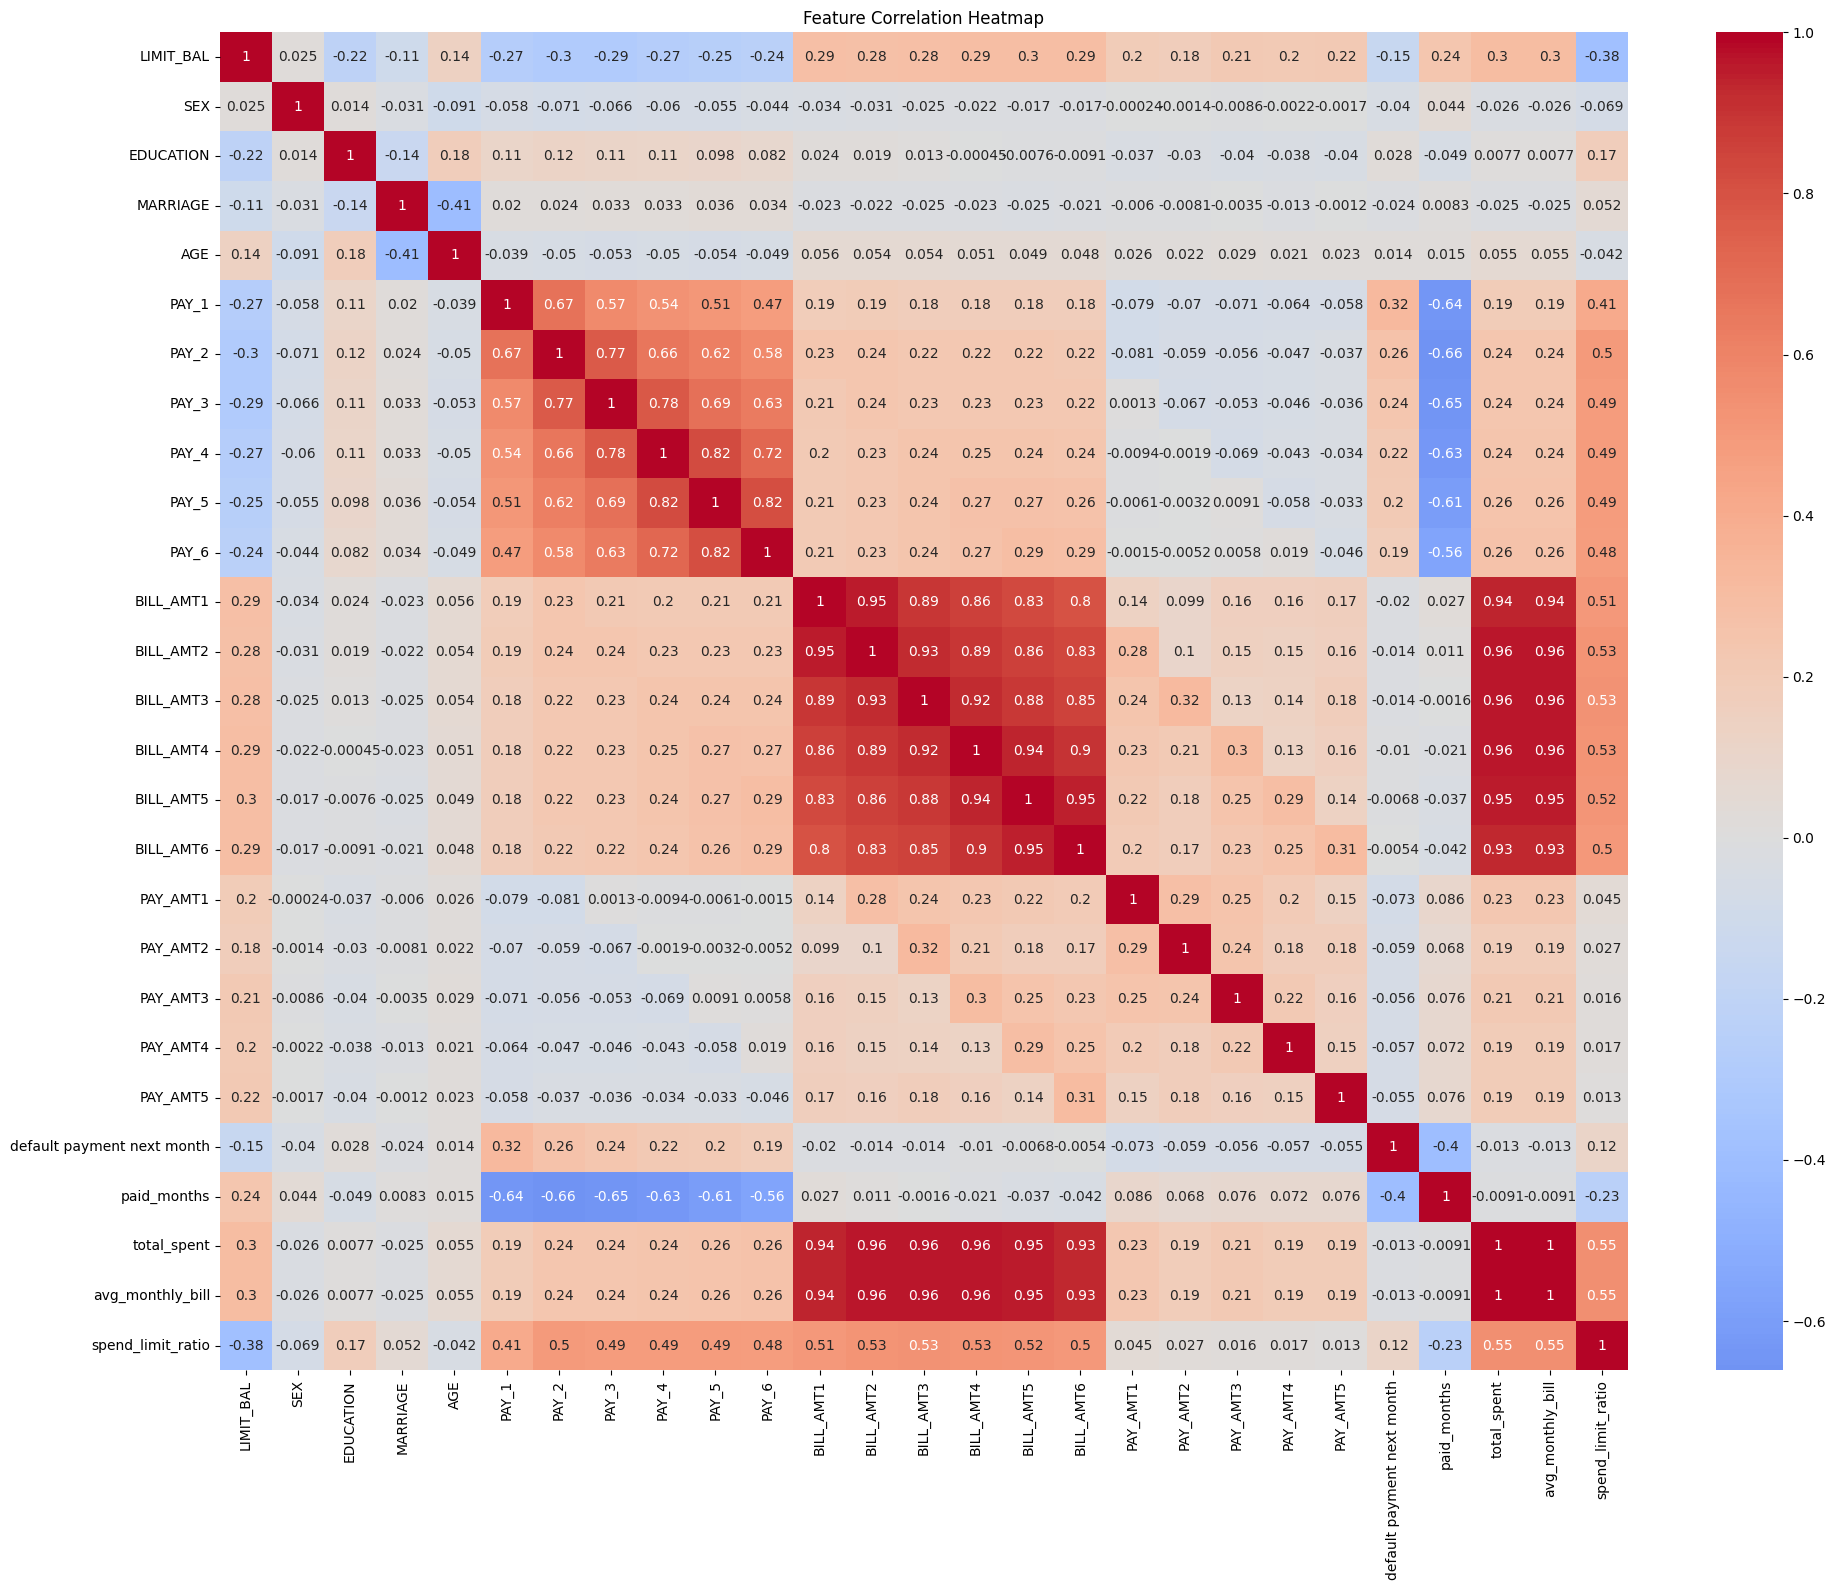

In [39]:
corr_matrix = df.corr()

plt.figure(figsize=(20, 16))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Feature Correlation Heatmap")
plt.tight_layout()
plt.show()


In [40]:
#check corr cols
corr_matrix = df.corr(numeric_only=True).abs()
upper = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
)

high_corr_pairs = [
    (col1, col2, upper.loc[col1, col2])
    for col1 in upper.columns
    for col2 in upper.columns
    if upper.loc[col1, col2] > 0.8
]
high_corr_df = pd.DataFrame(high_corr_pairs, columns=["Feature_1", "Feature_2", "Correlation"])

print(high_corr_df)


      Feature_1         Feature_2  Correlation
0         PAY_4             PAY_5     0.819835
1         PAY_5             PAY_6     0.816900
2     BILL_AMT1         BILL_AMT2     0.951484
3     BILL_AMT1         BILL_AMT3     0.892279
4     BILL_AMT1         BILL_AMT4     0.860272
5     BILL_AMT1         BILL_AMT5     0.829779
6     BILL_AMT1         BILL_AMT6     0.802650
7     BILL_AMT1       total_spent     0.940100
8     BILL_AMT1  avg_monthly_bill     0.940100
9     BILL_AMT2         BILL_AMT3     0.928326
10    BILL_AMT2         BILL_AMT4     0.892482
11    BILL_AMT2         BILL_AMT5     0.859778
12    BILL_AMT2         BILL_AMT6     0.831594
13    BILL_AMT2       total_spent     0.961178
14    BILL_AMT2  avg_monthly_bill     0.961178
15    BILL_AMT3         BILL_AMT4     0.923969
16    BILL_AMT3         BILL_AMT5     0.883910
17    BILL_AMT3         BILL_AMT6     0.853320
18    BILL_AMT3       total_spent     0.961958
19    BILL_AMT3  avg_monthly_bill     0.961958
20    BILL_AM

In [41]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = df[['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'total_spent', 'PAY_4', 'PAY_6','avg_monthly_bill', 'PAY_5']]
vif = pd.DataFrame()
vif['Feature'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif)


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


             Feature       VIF
0          BILL_AMT1       inf
1          BILL_AMT2       inf
2          BILL_AMT3       inf
3          BILL_AMT4       inf
4          BILL_AMT5       inf
5          BILL_AMT6       inf
6        total_spent       inf
7              PAY_4  3.272076
8              PAY_6  3.301073
9   avg_monthly_bill       inf
10             PAY_5  4.853857


In [42]:
cols_to_drop = [
    'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3',
    'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
    'total_spent'
]
df.drop(columns=cols_to_drop, inplace=True)

In [43]:
df.shape

(30000, 20)

In [44]:
df.columns

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_1', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3',
       'PAY_AMT4', 'PAY_AMT5', 'default payment next month', 'paid_months',
       'avg_monthly_bill', 'spend_limit_ratio'],
      dtype='object')

In [45]:
df['paid_months'].unique()

array([4, 6, 5, 2, 1, 0, 3], dtype=int64)

In [46]:
categorical_cols = ['SEX', 'EDUCATION', 'MARRIAGE',
                    'PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']

for col in categorical_cols:
    df[col] = df[col].astype('category')

df['default payment next month'] = df['default payment next month'].astype('category')


In [49]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import mlflow
import mlflow.sklearn
import mlflow.xgboost
import mlflow.lightgbm
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

mlflow.set_tracking_uri('http://127.0.0.1:5000')

def log_model_to_mlflow(model, X_test, y_test, model_name, features_used):
    with mlflow.start_run(run_name=model_name):
        preds = model.predict(X_test)

        mlflow.log_metric("accuracy", accuracy_score(y_test, preds))
        mlflow.log_metric("f1_score", f1_score(y_test, preds))
        mlflow.log_metric("f1_weighted", f1_score(y_test, preds, average="weighted"))
        mlflow.log_metric("precision", precision_score(y_test, preds))
        mlflow.log_metric("recall", recall_score(y_test, preds))

        if hasattr(model, "get_params"):
            for k, v in model.get_params().items():
                mlflow.log_param(k, v)
        mlflow.log_param("model", model_name)
        mlflow.log_param("features", str(list(features_used)))

        
        if "xgb" in model_name.lower():
            mlflow.xgboost.log_model(model, "model")
        elif "lgb" in model_name.lower():
            mlflow.lightgbm.log_model(model, "model")
        else:
            mlflow.sklearn.log_model(model, "model")

categorical_cols = ['SEX', 'EDUCATION', 'MARRIAGE',
                    'PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
target_col = 'default payment next month'


def evaluate_model(name, model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    print(f"\n=== {name} ===")
    print(f"Train Accuracy: {accuracy_score(y_train, y_train_pred):.4f}, F1: {f1_score(y_train, y_train_pred):.4f}")
    print(f"Test  Accuracy: {accuracy_score(y_test, y_test_pred):.4f}, F1: {f1_score(y_test, y_test_pred):.4f}")
    print("Confusion Matrix (Test):")
    print(confusion_matrix(y_test, y_test_pred))

    
    log_model_to_mlflow(model, X_test, y_test, name, X_train.columns)


#  One-Hot Encoding + Standard Scaling 
df_onehot = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
X1 = df_onehot.drop(target_col, axis=1)
y1 = df[target_col].astype('int')

scaler = StandardScaler()
X1[X1.columns] = scaler.fit_transform(X1)

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=42, stratify=y1)

models_onehot = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier()
}

print("=== One-Hot Encoded Models ===")
for name, model in models_onehot.items():
    evaluate_model(name, model, X1_train, X1_test, y1_train, y1_test)

# Label Encoding
df_label = df.copy()
for col in categorical_cols:
    df_label[col] = LabelEncoder().fit_transform(df_label[col])

X2 = df_label.drop(target_col, axis=1)
y2 = df_label[target_col].astype('int')

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=42, stratify=y2)

models_label = {
    "Random Forest": RandomForestClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "LightGBM": LGBMClassifier()
}

print("\n=== Label Encoded Models ===")
for name, model in models_label.items():
    evaluate_model(name, model, X2_train, X2_test, y2_train, y2_test)


=== One-Hot Encoded Models ===

=== Logistic Regression ===
Train Accuracy: 0.8221, F1: 0.4722
Test  Accuracy: 0.8162, F1: 0.4585
Confusion Matrix (Test):
[[4430  243]
 [ 860  467]]


2025/05/13 16:03:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Logistic Regression at: http://127.0.0.1:5000/#/experiments/0/runs/4a1568de2064411d97523d3fdb16efba
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0

=== KNN ===
Train Accuracy: 0.8437, F1: 0.5730
Test  Accuracy: 0.8018, F1: 0.4558
Confusion Matrix (Test):
[[4313  360]
 [ 829  498]]


2025/05/13 16:03:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run KNN at: http://127.0.0.1:5000/#/experiments/0/runs/b44bc566434b41238db75bcaf4ee4bd8
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0

=== Label Encoded Models ===

=== Random Forest ===
Train Accuracy: 0.9994, F1: 0.9987
Test  Accuracy: 0.8098, F1: 0.4590
Confusion Matrix (Test):
[[4375  298]
 [ 843  484]]


2025/05/13 16:04:02 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Random Forest at: http://127.0.0.1:5000/#/experiments/0/runs/0dbd8c01f29b4e4aba834ed86bce10b0
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [16:04:02] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



=== XGBoost ===
Train Accuracy: 0.8808, F1: 0.6658
Test  Accuracy: 0.8138, F1: 0.4648
Confusion Matrix (Test):
[[4398  275]
 [ 842  485]]


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:1028: UserWarning: [16:04:04] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\c_api\c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)
2025/05/13 16:04:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run XGBoost at: http://127.0.0.1:5000/#/experiments/0/runs/5023586782ee411387eeb2f463dec2f4
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0

=== LightGBM ===
Train Accuracy: 0.8428, F1: 0.5416
Test  Accuracy: 0.8170, F1: 0.4623
Confusion Matrix (Test):
[[4430  243]
 [ 855  472]]


2025/05/13 16:04:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run LightGBM at: http://127.0.0.1:5000/#/experiments/0/runs/02f8539ea19149789a85a52a6952712d
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0


In [50]:
df.shape

(30000, 20)

In [51]:
X1_train.shape

(24000, 78)

In [52]:
X2_train.shape

(24000, 19)

In [53]:
import optuna
from sklearn.model_selection import cross_val_score

X2_opt = X2
y2_opt = y2

#Tune Random Forest 
def rf_objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
    }
    model = RandomForestClassifier(**params,random_state=42, n_jobs=-1)
    return cross_val_score(model, X2_opt, y2_opt, cv=3, scoring='f1').mean()

study_rf = optuna.create_study(direction='maximize')
study_rf.optimize(rf_objective, n_trials=25)
print("\nBest Random Forest Params:", study_rf.best_params)

# Tune XGBoost 
def xgb_objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1.0)
        
    }
    model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', **params,random_state=42, n_jobs=-1)
    return cross_val_score(model, X2_opt, y2_opt, cv=3, scoring='f1').mean()

study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(xgb_objective, n_trials=25)
print("\nBest XGBoost Params:", study_xgb.best_params)

#Tune LightGBM 
def lgbm_objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 400),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.6, 1.0),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0)
    }
    model = LGBMClassifier(**params, random_state=42,verbose=-1,verbosity=-1, n_jobs=-1)
    return cross_val_score(model, X2_opt, y2_opt, cv=3, scoring='f1').mean()

study_lgb = optuna.create_study(direction='maximize')
study_lgb.optimize(lgbm_objective, n_trials=25)
print("\nBest LightGBM Params:", study_lgb.best_params)


[I 2025-05-13 16:04:27,477] A new study created in memory with name: no-name-0b574e36-4d6a-44cd-ac32-f242fe720b2c
[I 2025-05-13 16:04:32,917] Trial 0 finished with value: 0.45320639704133664 and parameters: {'n_estimators': 166, 'max_depth': 4, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 0 with value: 0.45320639704133664.
[I 2025-05-13 16:04:42,208] Trial 1 finished with value: 0.47211147704563183 and parameters: {'n_estimators': 176, 'max_depth': 12, 'min_samples_split': 7, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 1 with value: 0.47211147704563183.
[I 2025-05-13 16:04:53,189] Trial 2 finished with value: 0.47120670520837576 and parameters: {'n_estimators': 174, 'max_depth': 15, 'min_samples_split': 7, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.47211147704563183.
[I 2025-05-13 16:05:07,068] Trial 3 finished with value: 0.4727002684702741 and parameters: {'n_estimators': 306, 'max_depth': 9


Best Random Forest Params: {'n_estimators': 104, 'max_depth': 12, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'log2'}


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [16:09:04] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [16:09:04] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
[I 2025-05-13 16:09:05,346] Trial 0 finished with value: 0.46915597933099074 and parameters: {'n_estimators': 124, 'max_depth': 3, 'learning_rate': 0.05051527641473066, 'subsample': 0.6592252798611427, 'colsample_bytree': 0.8009321493552315, 'gamma': 0.11891377486338173, 'reg_alpha': 0.1541333979324122, 'reg_lambda': 0.7264919682741032}. Best is trial 0 with value: 0.46915597933099074.
C:\Users\Admin\AppData\Local\Programs


Best XGBoost Params: {'n_estimators': 158, 'max_depth': 5, 'learning_rate': 0.1679502937475585, 'subsample': 0.8959703172176144, 'colsample_bytree': 0.8344880082953717, 'gamma': 4.897915721423871, 'reg_alpha': 0.04276481735720328, 'reg_lambda': 0.4683129185752942}


[I 2025-05-13 16:10:35,154] Trial 0 finished with value: 0.45017873386977453 and parameters: {'n_estimators': 265, 'max_depth': 9, 'learning_rate': 0.2374908252478953, 'num_leaves': 145, 'feature_fraction': 0.748186765764987, 'subsample': 0.657838366122466, 'colsample_bytree': 0.96980131720298, 'reg_alpha': 0.3338388662017835, 'reg_lambda': 0.6221548458350593}. Best is trial 0 with value: 0.45017873386977453.
[I 2025-05-13 16:11:04,732] Trial 1 finished with value: 0.4591958731498668 and parameters: {'n_estimators': 327, 'max_depth': 9, 'learning_rate': 0.053031187732492456, 'num_leaves': 128, 'feature_fraction': 0.6797732865037018, 'subsample': 0.7686153793781347, 'colsample_bytree': 0.6411605206610692, 'reg_alpha': 0.17486425930244465, 'reg_lambda': 0.5946094660400684}. Best is trial 1 with value: 0.4591958731498668.
[I 2025-05-13 16:11:09,229] Trial 2 finished with value: 0.4671807858127493 and parameters: {'n_estimators': 334, 'max_depth': 3, 'learning_rate': 0.1268199896316206, 'n


Best LightGBM Params: {'n_estimators': 179, 'max_depth': 3, 'learning_rate': 0.2709871988448979, 'num_leaves': 58, 'feature_fraction': 0.6070990730774157, 'subsample': 0.6257071654916461, 'colsample_bytree': 0.7296255320345254, 'reg_alpha': 0.37190367776998956, 'reg_lambda': 0.19046605981890896}


In [64]:
def log_tuned_model_mlflow(model, model_name, X_test, y_test, features, best_params):
    with mlflow.start_run(run_name=f"{model_name} Tuned"):
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]

        mlflow.log_metric("accuracy", accuracy_score(y_test, y_pred))
        mlflow.log_metric("f1_score", f1_score(y_test, y_pred))
        mlflow.log_metric("f1_weighted", f1_score(y_test, y_pred, average="weighted"))
        mlflow.log_metric("precision", precision_score(y_test, y_pred))
        mlflow.log_metric("recall", recall_score(y_test, y_pred))
        mlflow.log_metric("auc", roc_auc_score(y_test, y_proba))

        mlflow.log_param("model", model_name + " Tuned")
        for k, v in best_params.items():
            mlflow.log_param(k, v)
        mlflow.log_param("features", str(list(features)))

        if "xgb" in model_name.lower():
            mlflow.xgboost.log_model(model, "model")
        elif "lgb" in model_name.lower():
            mlflow.lightgbm.log_model(model, "model")
        else:
            mlflow.sklearn.log_model(model, "model")


In [55]:
from sklearn.metrics import roc_auc_score

#Tuned XGBoost Evaluation
best_xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', **study_xgb.best_params)
best_xgb.fit(X2_train, y2_train)

y_train_pred_xgb = best_xgb.predict(X2_train)
y_test_pred_xgb = best_xgb.predict(X2_test)
y_test_prob_xgb = best_xgb.predict_proba(X2_test)[:, 1]

print("\n=== Tuned XGBoost ===")
print(f"Train Accuracy: {accuracy_score(y2_train, y_train_pred_xgb):.4f}, F1: {f1_score(y2_train, y_train_pred_xgb):.4f}")
print(f"Test  Accuracy: {accuracy_score(y2_test, y_test_pred_xgb):.4f}, F1: {f1_score(y2_test, y_test_pred_xgb):.4f}, AUC: {roc_auc_score(y2_test, y_test_prob_xgb):.4f}")
print("Confusion Matrix (Test):")
print(confusion_matrix(y2_test, y_test_pred_xgb))

# Tuned LightGBM Evaluation 
best_lgb = LGBMClassifier(**study_lgb.best_params)
best_lgb.fit(X2_train, y2_train)

y_train_pred_lgb = best_lgb.predict(X2_train)
y_test_pred_lgb = best_lgb.predict(X2_test)
y_test_prob_lgb = best_lgb.predict_proba(X2_test)[:, 1]

print("\n=== Tuned LightGBM ===")
print(f"Train Accuracy: {accuracy_score(y2_train, y_train_pred_lgb):.4f}, F1: {f1_score(y2_train, y_train_pred_lgb):.4f}")
print(f"Test  Accuracy: {accuracy_score(y2_test, y_test_pred_lgb):.4f}, F1: {f1_score(y2_test, y_test_pred_lgb):.4f}, AUC: {roc_auc_score(y2_test, y_test_prob_lgb):.4f}")
print("Confusion Matrix (Test):")
print(confusion_matrix(y2_test, y_test_pred_lgb))

#Tuned Random Forest Evaluation
best_rf = RandomForestClassifier(**study_rf.best_params)
best_rf.fit(X2_train, y2_train)

y_train_pred_rf = best_rf.predict(X2_train)
y_test_pred_rf = best_rf.predict(X2_test)
y_test_prob_rf = best_rf.predict_proba(X2_test)[:, 1]

print("\n=== Tuned Random Forest ===")
print(f"Train Accuracy: {accuracy_score(y2_train, y_train_pred_rf):.4f}, F1: {f1_score(y2_train, y_train_pred_rf):.4f}")
print(f"Test  Accuracy: {accuracy_score(y2_test, y_test_pred_rf):.4f}, F1: {f1_score(y2_test, y_test_pred_rf):.4f}, AUC: {roc_auc_score(y2_test, y_test_prob_rf):.4f}")
print("Confusion Matrix (Test):")
print(confusion_matrix(y2_test, y_test_pred_rf))


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [16:14:49] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



=== Tuned XGBoost ===
Train Accuracy: 0.8275, F1: 0.4964
Test  Accuracy: 0.8180, F1: 0.4663, AUC: 0.7764
Confusion Matrix (Test):
[[4431  242]
 [ 850  477]]

=== Tuned LightGBM ===
Train Accuracy: 0.8347, F1: 0.5181
Test  Accuracy: 0.8153, F1: 0.4585, AUC: 0.7757
Confusion Matrix (Test):
[[4423  250]
 [ 858  469]]

=== Tuned Random Forest ===
Train Accuracy: 0.8545, F1: 0.5783
Test  Accuracy: 0.8162, F1: 0.4633, AUC: 0.7717
Confusion Matrix (Test):
[[4421  252]
 [ 851  476]]


In [65]:
log_tuned_model_mlflow(
    best_xgb, "XGBoost", X2_test, y2_test, X2_train.columns, study_xgb.best_params
)
log_tuned_model_mlflow(
    best_lgb, "LightGBM", X2_test, y2_test, X2_train.columns, study_lgb.best_params
)

log_tuned_model_mlflow(
    best_rf, "Random Forest", X2_test, y2_test, X2_train.columns, study_rf.best_params
)


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:1028: UserWarning: [16:19:14] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\c_api\c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)
2025/05/13 16:19:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run XGBoost Tuned at: http://127.0.0.1:5000/#/experiments/0/runs/f0a168b516ef4eea838a0ef3b08fbfe8
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0


2025/05/13 16:19:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run LightGBM Tuned at: http://127.0.0.1:5000/#/experiments/0/runs/fdfba056ed1a431ba2607685fdc75b0c
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0


2025/05/13 16:19:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Random Forest Tuned at: http://127.0.0.1:5000/#/experiments/0/runs/b6e6a6647bba42a88443bf536e3aa1a4
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0


In [57]:
from sklearn.calibration import calibration_curve
from sklearn.linear_model import LinearRegression

def plot_calibration_curve(y_true, y_prob, model_name):
    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=10, strategy='uniform')
    
    reg = LinearRegression().fit(prob_pred.reshape(-1, 1), prob_true)
    slope = reg.coef_[0]
    intercept = reg.intercept_

    plt.figure(figsize=(7, 5))
    plt.plot(prob_pred, prob_true, 'x-', color='skyblue', label='Smoothed Default Probabilities (Y)')
    plt.plot([0, 1], [0, 1], 'g--', label='Ideal Line: Y = X')
    plt.plot(prob_pred, reg.predict(prob_pred.reshape(-1, 1)), 'r-', label=f'Regression Line: Y = {intercept:.2f} + {slope:.2f}X')

    plt.xlabel("Predicted Probability of Default (X)")
    plt.ylabel("Smoothed Actual Default Rate (Y)")
    plt.title(f"Model Calibration: {model_name}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


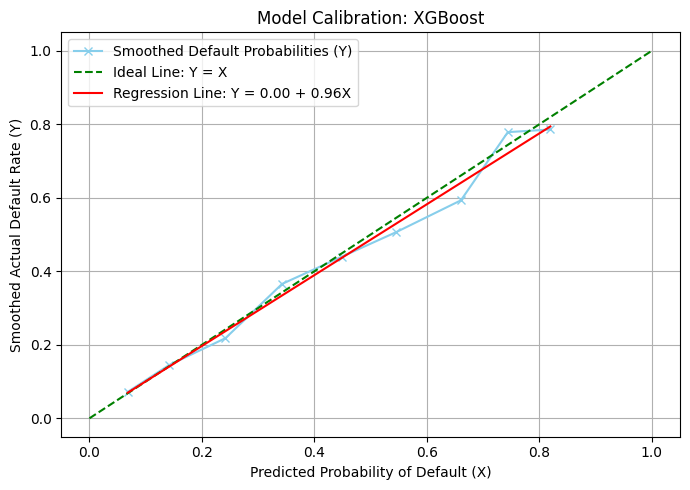

In [58]:
# XGBoost
plot_calibration_curve(y2_test, y_test_prob_xgb, "XGBoost")


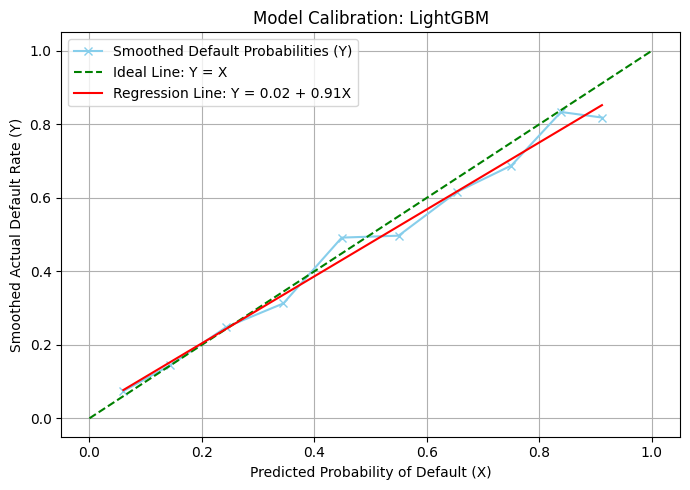

In [59]:
# LightGBM
plot_calibration_curve(y2_test, y_test_prob_lgb, "LightGBM")

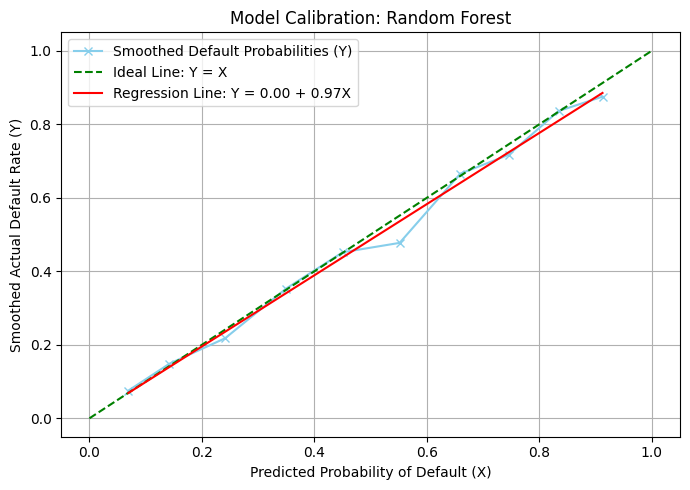

In [60]:
# Random Forest
plot_calibration_curve(y2_test, y_test_prob_rf, "Random Forest")

C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

Best Threshold: 0.32
Accuracy:     0.7968
F1 Score:     0.5259
F1 Weighted:  0.7944
Precision:    0.5434
Recall:       0.5094
Confusion Matrix:
 [[4105  568]
 [ 651  676]]


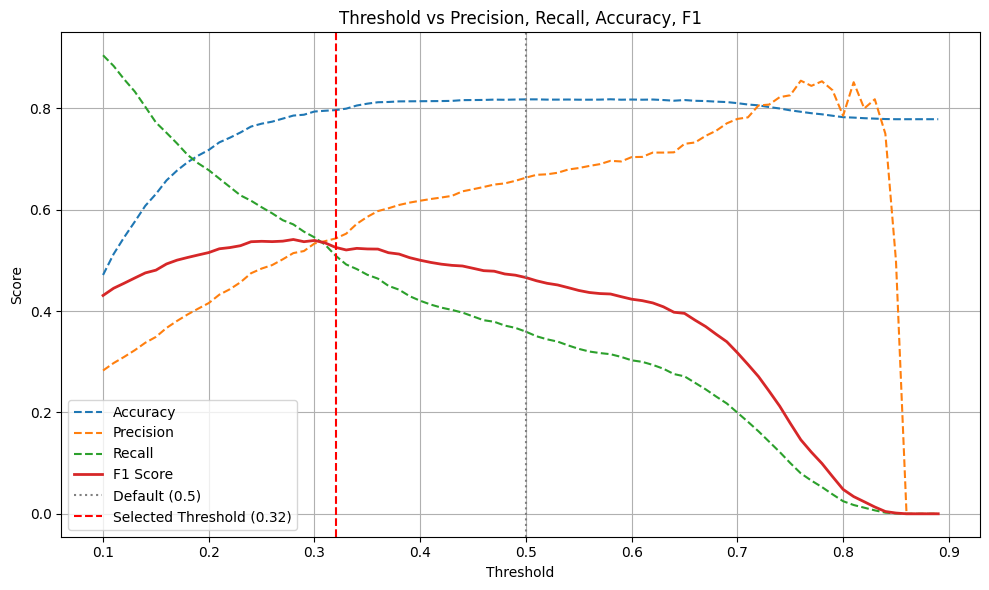

In [61]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix

thresholds = np.arange(0.1, 0.9, 0.01)

f1_scores = []
f1_weighted_scores = []
precisions = []
recalls = []
accuracies = []
conf_matrices = []
y_probs = best_xgb.predict_proba(X2_test)[:, 1]  
y_true = y2_test

for thresh in thresholds:
    y_pred = (y_probs >= thresh).astype(int)
    f1_scores.append(f1_score(y_true, y_pred))
    f1_weighted_scores.append(f1_score(y_true, y_pred, average='weighted'))
    precisions.append(precision_score(y_true, y_pred))
    recalls.append(recall_score(y_true, y_pred))
    accuracies.append(accuracy_score(y_true, y_pred))
    conf_matrices.append(confusion_matrix(y_true, y_pred))

# Choose threshold (manual or max F1)
# best_thresh = thresholds[np.argmax(f1_scores)] 
best_thresh = 0.32  # ma
best_idx = (np.abs(thresholds - best_thresh)).argmin()

print(f"Best Threshold: {best_thresh:.2f}")
print(f"Accuracy:     {accuracies[best_idx]:.4f}")
print(f"F1 Score:     {f1_scores[best_idx]:.4f}")
print(f"F1 Weighted:  {f1_weighted_scores[best_idx]:.4f}")
print(f"Precision:    {precisions[best_idx]:.4f}")
print(f"Recall:       {recalls[best_idx]:.4f}")
print("Confusion Matrix:\n", conf_matrices[best_idx])

plt.figure(figsize=(10, 6))
plt.plot(thresholds, accuracies, label='Accuracy', linestyle='--')
plt.plot(thresholds, precisions, label='Precision', linestyle='--')
plt.plot(thresholds, recalls, label='Recall', linestyle='--')
plt.plot(thresholds, f1_scores, label='F1 Score', linewidth=2)
plt.axvline(x=0.5, color='gray', linestyle=':', label='Default (0.5)')
plt.axvline(x=best_thresh, color='red', linestyle='--', label=f'Selected Threshold ({best_thresh:.2f})')
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Threshold vs Precision, Recall, Accuracy, F1")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [62]:
mlflow.end_run()

In [67]:
best_thresh = 0.32
best_idx = (np.abs(thresholds - best_thresh)).argmin()

f1 = f1_scores[best_idx]
f1_weighted = f1_weighted_scores[best_idx]
precision = precisions[best_idx]
recall = recalls[best_idx]
accuracy = accuracies[best_idx]
cm = conf_matrices[best_idx]

with mlflow.start_run(run_name="XGBoost Threshold Tuned"):
    
    mlflow.log_param("model", "XGBoost Thresh Tuned")
    mlflow.log_param("threshold", best_thresh)
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("f1_score", f1)
    mlflow.log_metric("f1_weighted", f1_weighted)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    mlflow.xgboost.log_model(best_xgb, "model")

    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, accuracies, label='Accuracy', linestyle='--')
    plt.plot(thresholds, precisions, label='Precision', linestyle='--')
    plt.plot(thresholds, recalls, label='Recall', linestyle='--')
    plt.plot(thresholds, f1_scores, label='F1 Score', linewidth=2)
    plt.axvline(x=0.5, color='gray', linestyle=':', label='Default (0.5)')
    plt.axvline(x=best_thresh, color='red', linestyle='--', label=f'Selected Threshold ({best_thresh:.2f})')
    plt.xlabel("Threshold")
    plt.ylabel("Score")
    plt.title("Threshold vs Precision, Recall, Accuracy, F1")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    with tempfile.NamedTemporaryFile(suffix=".png", delete=False) as tmpfile:
        plt.savefig(tmpfile.name)
        mlflow.log_artifact(tmpfile.name, artifact_path="threshold_tuning")
    plt.close()


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:1028: UserWarning: [16:21:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\c_api\c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)
2025/05/13 16:21:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run XGBoost Threshold Tuned at: http://127.0.0.1:5000/#/experiments/0/runs/24779248873343e28aa9af3ab7ef0feb
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0


# Credit Card Default Prediction

This project focuses on predicting whether a client will default on their credit card payment next month using various machine learning models. Multiple encoding, feature selection, and tuning strategies were explored to identify the best-performing model.

---

## Scenarios Explored

### 1. Encoding Techniques
-  **One-Hot Encoding**  
  Applied to categorical columns such as `SEX`, `EDUCATION`, `MARRIAGE`, and `PAY_1` to `PAY_6`. Suitable for linear models like Logistic Regression and KNN.

-  **Label Encoding**  
  Used for tree-based models to preserve ordinal relationships and reduce dimensionality.

### 2. Model Variants
- **Pre-tuned Models**  
  Default model parameters used for baseline evaluation.

- **Hyperparameter Tuning**  
  Utilized **Optuna** to optimize parameters for tree-based models.

- **Threshold Tuning**  
  Fine-tuned the classification threshold for better precision/recall trade-offs. The best threshold selected was `0.32`.

---


##  Business Objective Alignment

- The key objective is to **identify defaulters**, not just maximize accuracy.
- Therefore, the model was **threshold-tuned** to improve **recall** (catching defaulters) at a reasonable trade-off with precision.
- This resulted in a model that maintains a **balanced F1 score and accuracy**, while focusing on **minimizing false negatives** (i.e., missed defaulters).

---

##  Feature Selection Attempts

### PCA (Principal Component Analysis)
- Applied dimensionality reduction using PCA.
- **Result**: Model performance **dropped**, likely due to loss of important feature interpretability.

### RFE (Recursive Feature Elimination)
- Applied RFE to select top-ranked features.
- **Result**: Slight drop in model performance compared to using full features.

### Extracted + Combined Features
- Created new features like `DIFFs`, `isFullyPaid`, and others, ending up with **33 columns**.
- **Observation**: Model performance remained **similar** to using fewer selected features (around 18–20 columns).

---

##  Best Model

- **Model**: `XGBoost`
- **Encoding**: `Label Encoding`
- **Tuning Applied**:
  - Optuna Hyperparameter Optimization
  - Threshold Tuning (Threshold: `0.32`)
- **Performance**:
  - **Accuracy**: ~0.79
  - **F1 Score**: ~0.54
  - **AUC**: ~0.77

---

## Experiment Tracking

All models and experiments were tracked using **MLflow**:

- Parameters: model type, threshold, and hyperparameters
- Metrics: accuracy, precision, recall, f1 score, f1 weighted, AUC
- Artifacts:
  - Trained model
  - Threshold tuning curve
  - Feature list

Each model variant (pre-tuned, tuned, threshold-tuned) was logged as a separate MLflow run for easy comparison.

---

##  Future Improvements

- Integrate explainability using SHAP/LIME
- Deploy the best model via FastAPI
- Add data drift detection and monitoring with Evidently.ai


---

##  Model Choice Rationale

### Tree-Based Models Over Logistic Regression and KNN

While Logistic Regression (LR) and K-Nearest Neighbors (KNN) were evaluated as baseline models, tree-based models were chosen for the following reasons:

####  Shortcomings of Logistic Regression:
- Assumes **linear relationships** between input features and the target, which may not hold true in real-world financial data.
- Less effective with **high-dimensional categorical data** even after encoding.
- Cannot capture **complex feature interactions** unless manually created.

####  Shortcomings of KNN:
- Performs poorly on **high-dimensional data** due to the curse of dimensionality.
- Very **slow at prediction time**, especially with large datasets.
- Requires careful scaling and **distance metric tuning**.

#### Tree-Based Models:
- Handle both **numerical and categorical features** natively (after label encoding).
- Can model **non-linear relationships** and **feature interactions** automatically.
- More **robust to outliers** and missing values.
- Provide **feature importance**, aiding interpretability.

---

###  XGBoost Over Random Forest and LightGBM

All three tree-based ensemble models (RF, LGBM, XGBoost) were evaluated under the same conditions using:
- Label-encoded data
- Optuna hyperparameter tuning
- Common evaluation metrics

#### XGBoost was chosen because:
- Showed **better generalization** on the test set with higher F1 score and AUC.
- Performed well after **threshold tuning**, achieving a balance between precision and recall.
- Offers better **control over regularization**, reducing overfitting.
- Consistent and **stable performance** across multiple feature sets and experiments.

####  LightGBM:
- Very close in performance, with slightly faster training.
- But showed slightly lower F1 score after threshold tuning.

####  Random Forest:
- Good baseline performance.
- Less tunable and lacks the same level of **boosting control** as XGBoost or LightGBM.

---

